# Planar flow

In [1]:
# Import required packages
import torch
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
K = 16
#torch.manual_seed(0)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

flows = []
for i in range(K):
    flows += [nf.flows.Planar((2,))]
target = nf.distributions.TwoModes(2, 0.1)

q0 = nf.distributions.DiagGaussian(2)
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)
nfm.to(device)

print(dir(nfm))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hoo

/home/mahrokhg/anaconda3/envs/NOC/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755934348/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


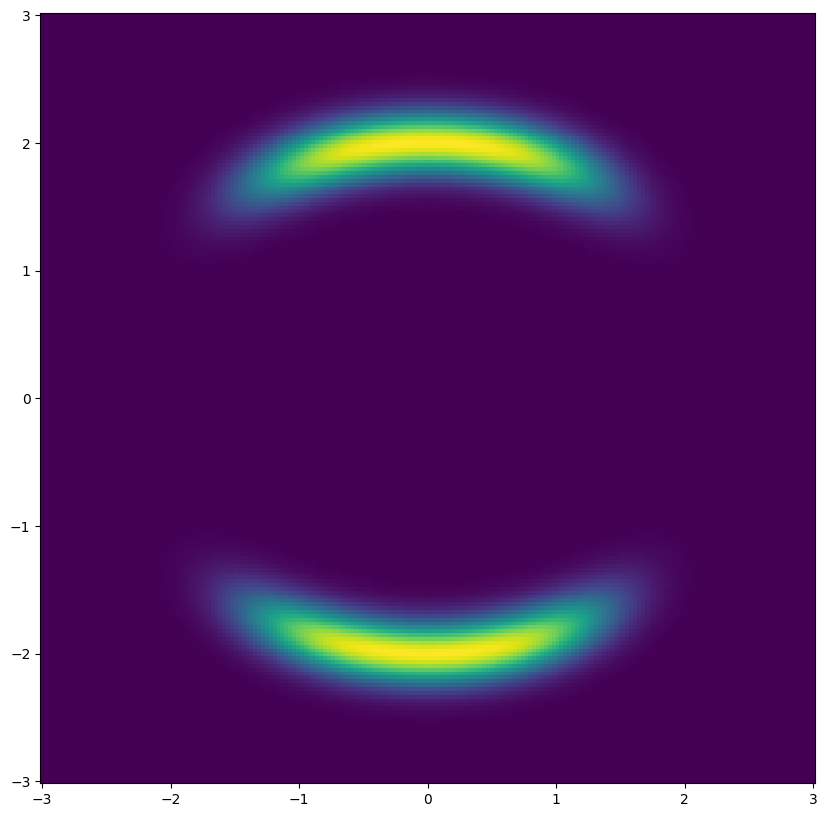

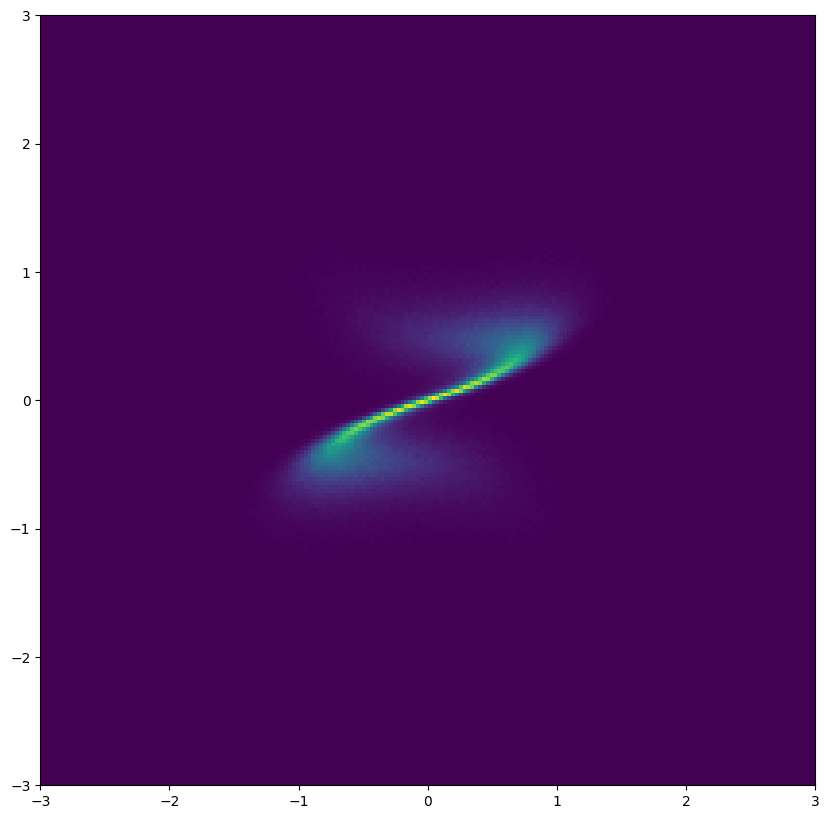

In [3]:
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
log_prob = target.log_prob(z.to(device)).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)

plt.figure(figsize=(10, 10))
plt.pcolormesh(torch.linspace(-3, 3, grid_size),torch.linspace(-3, 3, grid_size), prob, shading='nearest')
plt.show()

# Plot initial flow distribution
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(10, 10))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

 10%|▉         | 1996/20000 [00:53<08:03, 37.26it/s]

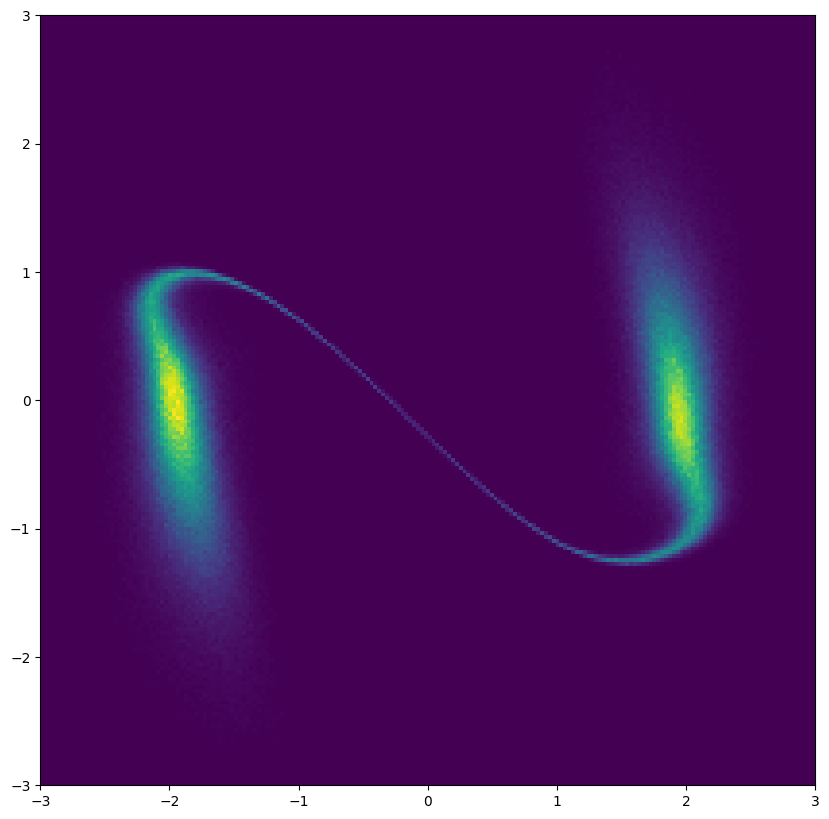

 20%|█▉        | 3997/20000 [01:47<07:21, 36.25it/s]

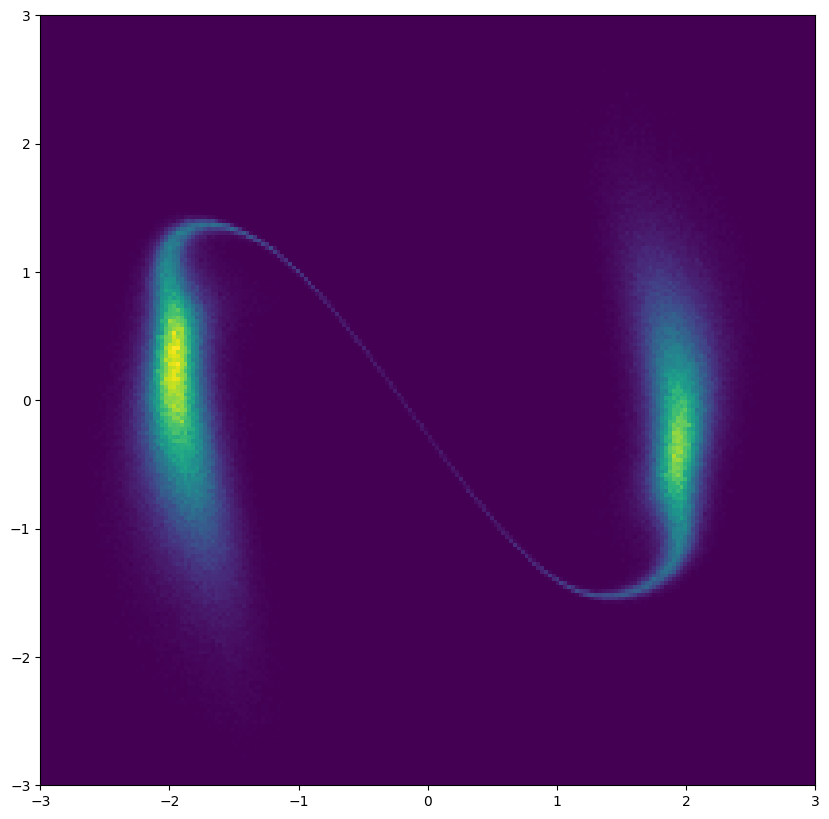

 30%|██▉       | 5998/20000 [02:43<06:17, 37.13it/s]

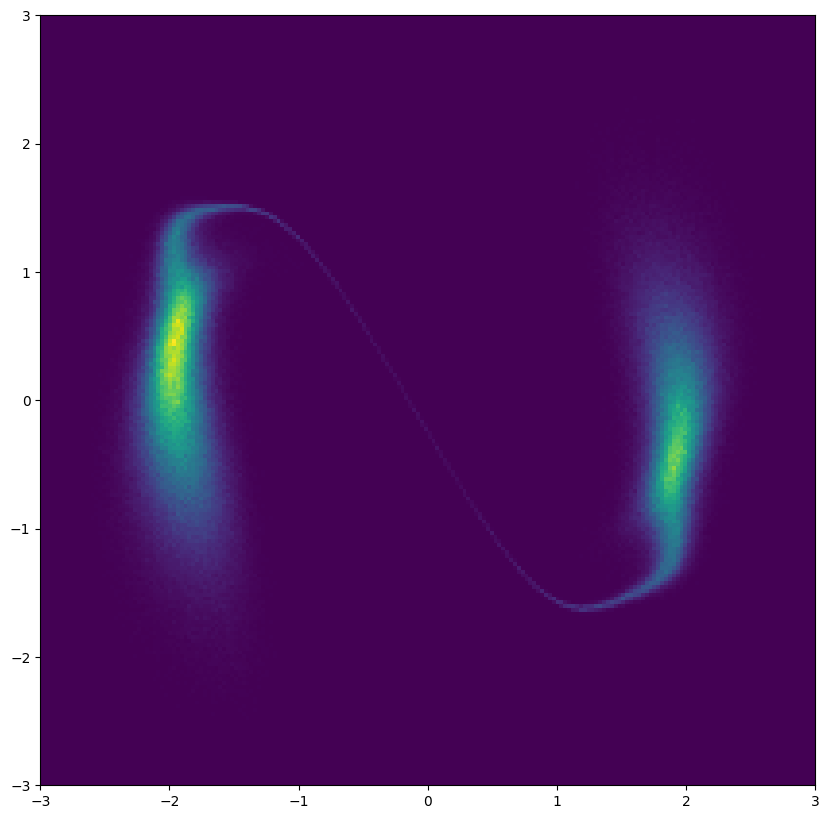

 40%|███▉      | 7998/20000 [03:32<05:22, 37.16it/s]

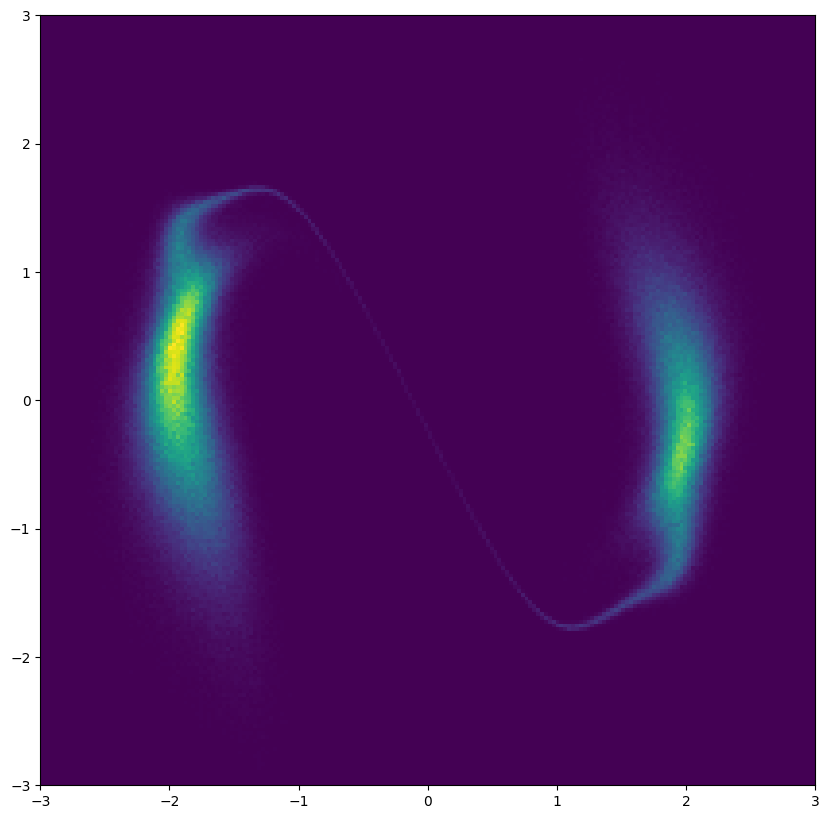

 50%|████▉     | 9999/20000 [04:27<04:29, 37.08it/s]

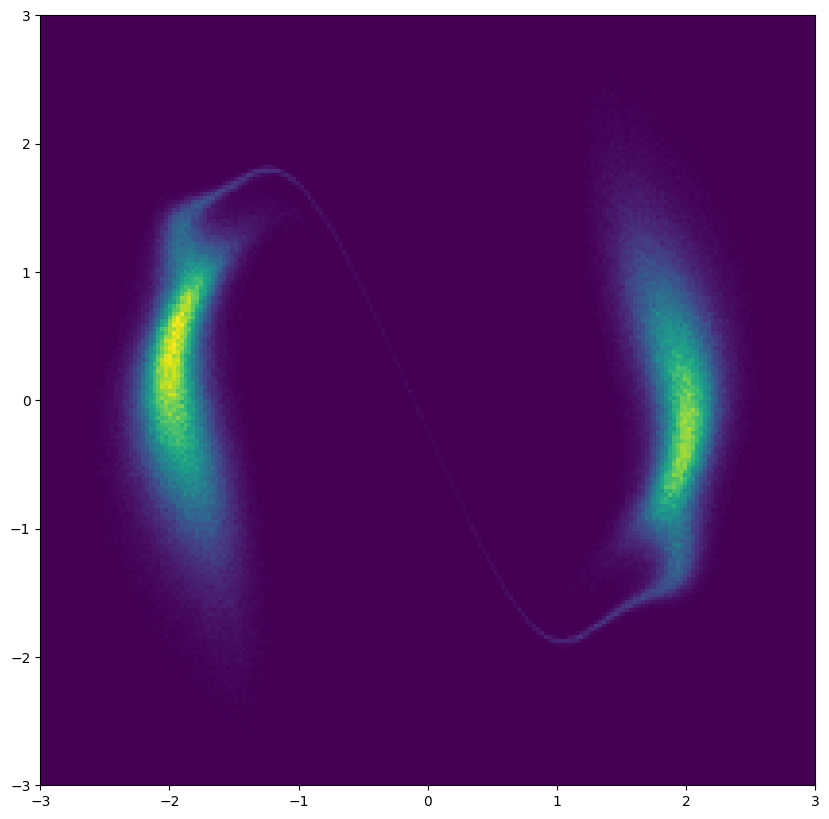

 60%|█████▉    | 11997/20000 [05:21<03:36, 37.02it/s]

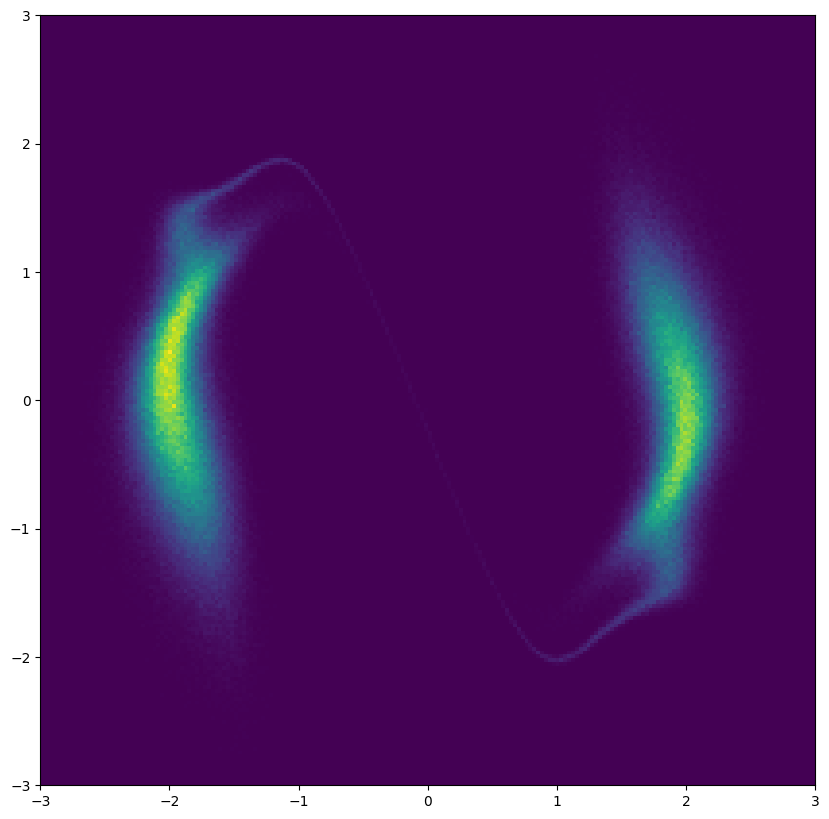

 70%|██████▉   | 13998/20000 [06:16<02:38, 37.81it/s]

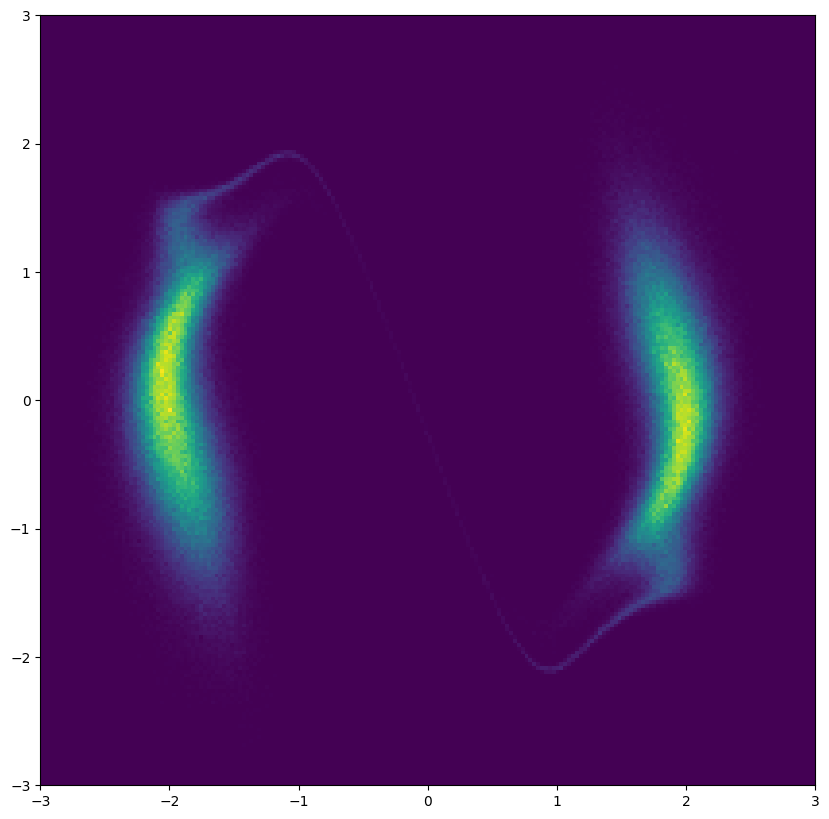

 80%|███████▉  | 15999/20000 [07:09<01:46, 37.72it/s]

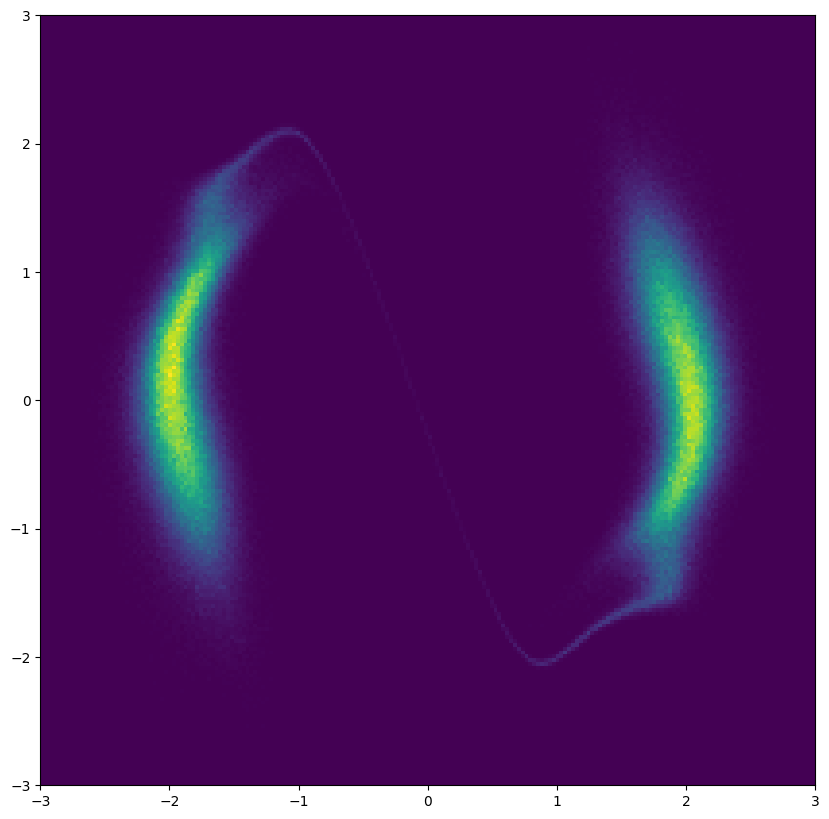

 90%|████████▉ | 17996/20000 [08:02<00:53, 37.73it/s]

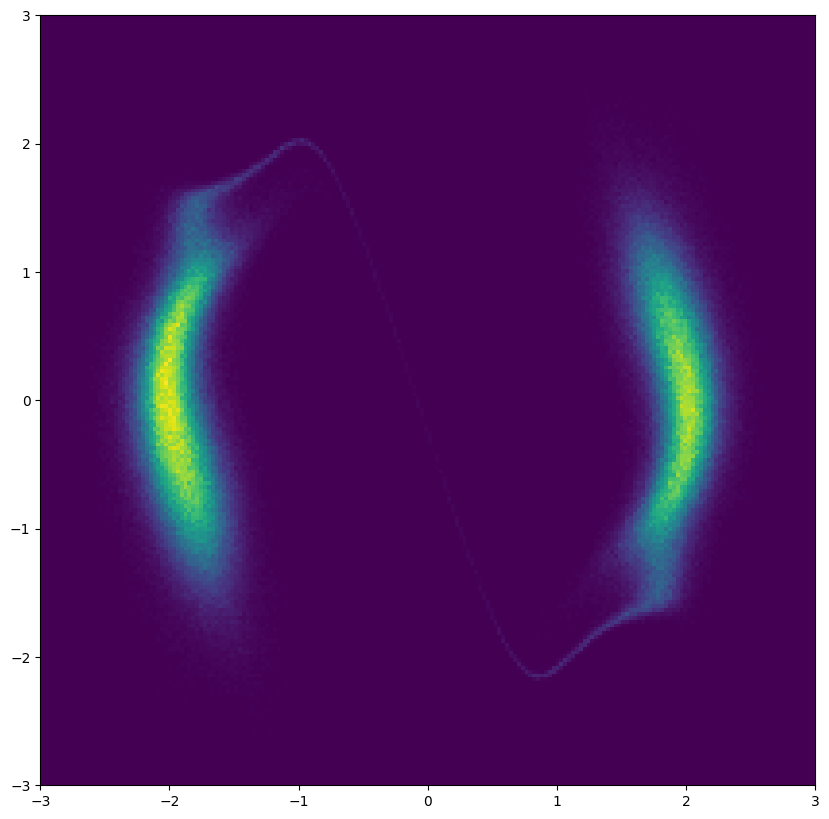

100%|█████████▉| 19997/20000 [08:55<00:00, 37.87it/s]

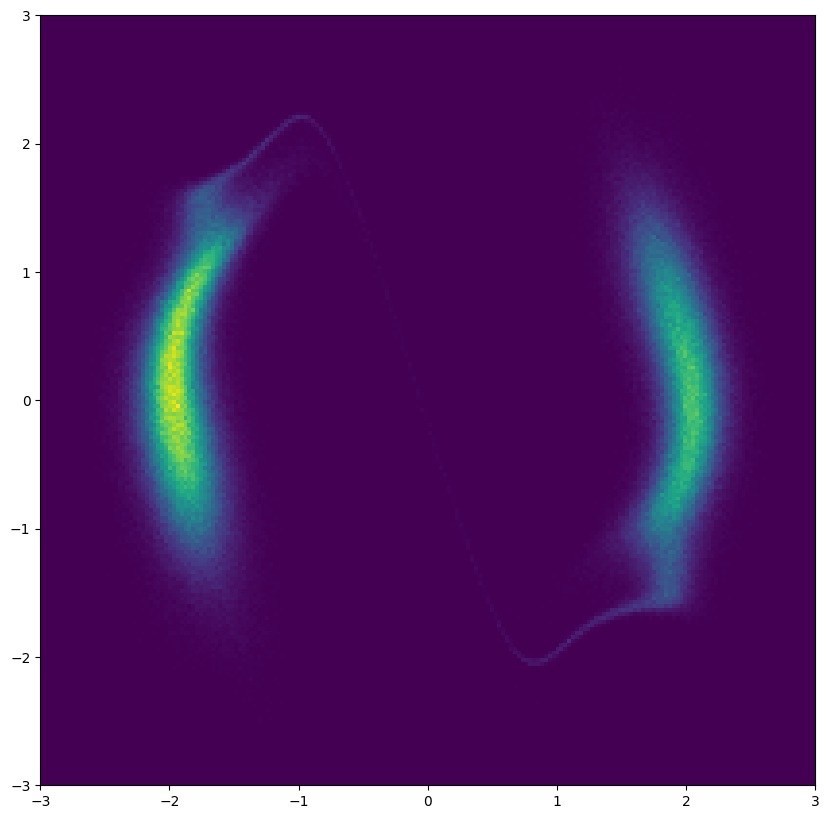

100%|██████████| 20000/20000 [08:55<00:00, 37.33it/s]


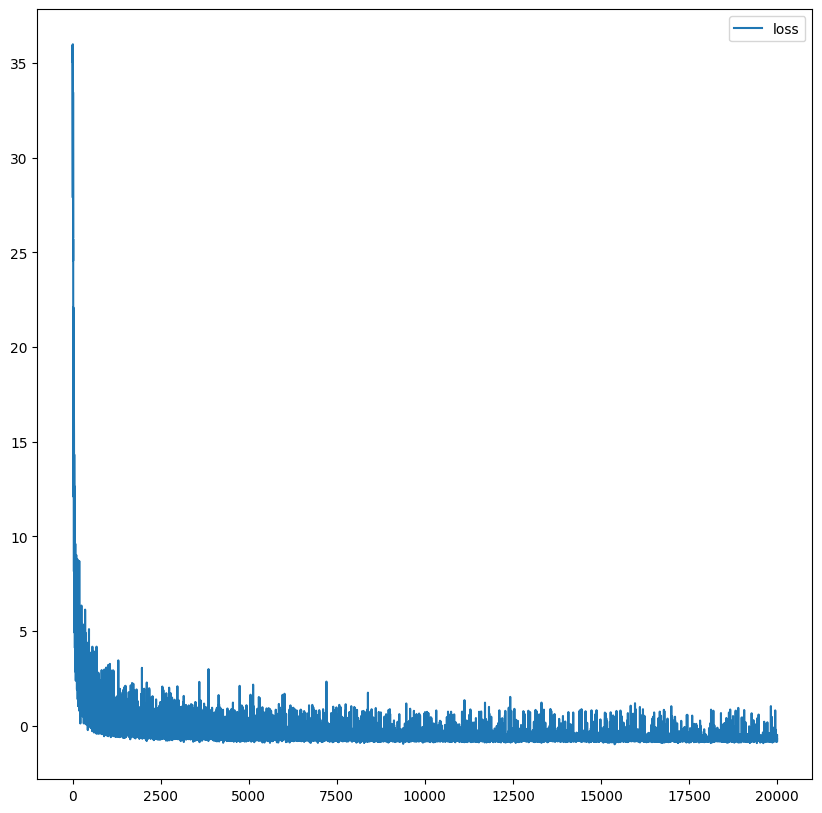

In [4]:
# Train model
max_iter = 20000
num_samples = 2 * 20
anneal_iter = 10000
annealing = False
show_iter = 2000


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = nfm.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = nfm.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        torch.cuda.manual_seed(0)
        z, _ = nfm.sample(num_samples=2 ** 20)
        z_np = z.to('cpu').data.numpy()
        
        plt.figure(figsize=(10, 10))
        plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
        plt.show()

plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

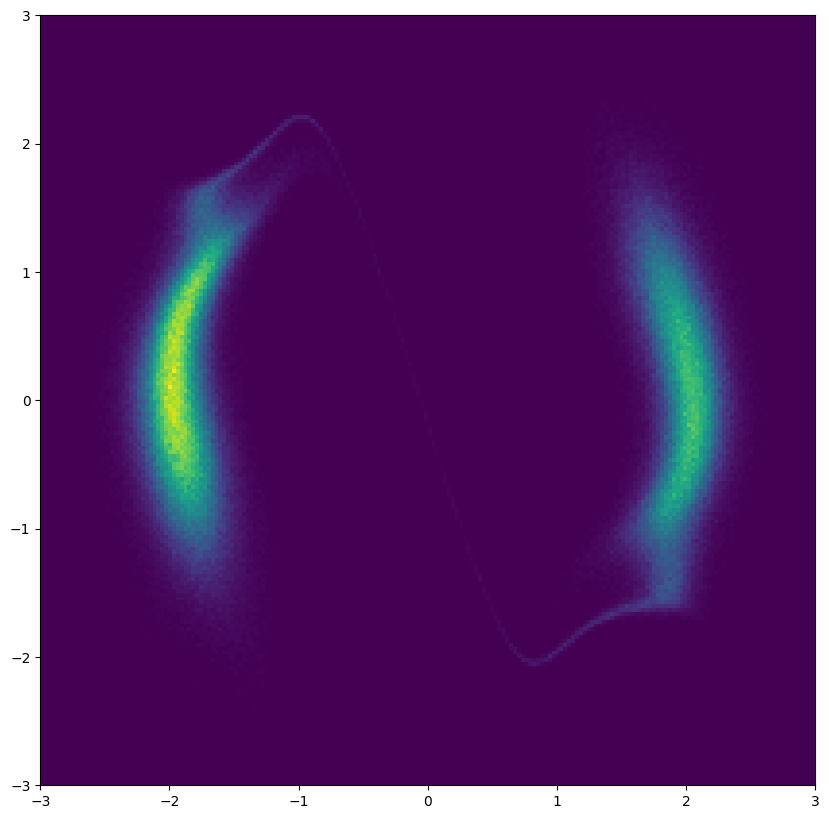

In [5]:
# Plot learned distribution
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(10, 10))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()